## Data-processing

In [2]:
import os
import glob
import pandas as pd
from sklearn.model_selection import train_test_split

image_data = "/home/mhs/thesis/new_labeled_dataset"

records = []

for folder in os.listdir(image_data):
    patient_dir = os.path.join(image_data, folder)
    if not os.path.isdir(patient_dir):
        continue
    oasis_id, label = folder.split('_', 1)
    for seq in ['anat1','anat2','anat3','dwi1','swi1','swi2']:
        seq_dir = os.path.join(patient_dir, seq)
        if not os.path.isdir(seq_dir):
            continue
        for ext in ('*.png','*.jpg','*.jpeg','*.nii','*.nii.gz','*.dcm'):
            for img_path in glob.glob(os.path.join(seq_dir, ext)):
                records.append({
                    'oasis_id':  oasis_id,
                    'image_path': img_path,
                    'label':      label
                })
                
df = pd.DataFrame(records)
df.head()

,oasis_id,image_path,label
0,OAS42381,/home/mhs/thesis/new_labeled_dataset/OAS42381_...,normal
1,OAS42381,/home/mhs/thesis/new_labeled_dataset/OAS42381_...,normal
2,OAS42381,/home/mhs/thesis/new_labeled_dataset/OAS42381_...,normal
3,OAS42381,/home/mhs/thesis/new_labeled_dataset/OAS42381_...,normal
4,OAS42381,/home/mhs/thesis/new_labeled_dataset/OAS42381_...,normal


In [3]:
df = pd.DataFrame(records)

In [4]:
from PIL import Image
import numpy as np

paths = df['image_path'].tolist()
labels = df['label'].tolist()

images = []
for p in paths:
    with Image.open(p) as img:
        img = img.convert("RGB")  # ensure 3-channel
        # use LANCZOS for high-quality downsampling
        img = img.resize((256, 256), resample=Image.Resampling.LANCZOS)
        images.append(np.array(img))


label
mild_dimentia          738
moderate_dimentia      240
normal                 402
very_mild_dimentia    2274
Name: count, dtype: int64


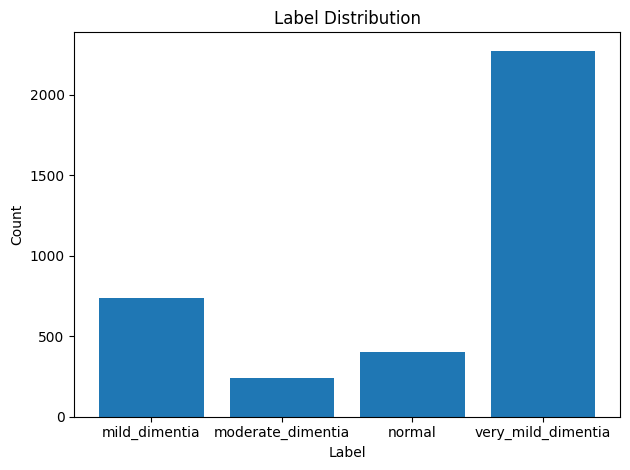

In [5]:
import matplotlib.pyplot as plt

# 1. Compute counts per label
label_counts = df['label'].value_counts().sort_index()
print(label_counts)  # shows e.g. label 0: 120, label 1: 380, …

# 2. Plot as a bar chart
plt.figure()
plt.bar(label_counts.index.astype(str), label_counts.values)
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [ ]:
import random
from collections import Counter

import numpy as np
from PIL import Image
from torchvision import transforms as T

# assume:
#   images = [H×W×C NumPy arrays]
#   labels = [int class IDs]

# 1) define your augmentation (rotation, flip, zoom)
augment = T.Compose([
    T.RandomHorizontalFlip(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # T.RandomAffine(degrees=30, scale=(0.8, 1.2)),  # rotate ±30°, zoom 0.8–1.2×
    # T.CenterCrop(256),                              # ensure 256×256 output
])

# 2) find how many each class has
counts = Counter(labels)
max_count = max(counts.values())

# 3) build balanced lists
X_balanced = []
y_balanced = []

for cls, cnt in counts.items():
    # indices of this class
    idxs = [i for i, y in enumerate(labels) if y == cls]
    
    # 3a) add all the originals
    for i in idxs:
        X_balanced.append(images[i])
        y_balanced.append(cls)
    
    # 3b) augment until we reach max_count
    n_needed = max_count - cnt
    for _ in range(n_needed):
        orig_i = random.choice(idxs)
        pil = Image.fromarray(images[orig_i])
        aug_pil = augment(pil)
        aug_np = np.array(aug_pil)
        X_balanced.append(aug_np)
        y_balanced.append(cls)

# 4) (optional) convert to arrays
X_balanced = np.stack(X_balanced, axis=0)  # shape: (num_classes*max_count, 256, 256, C)
y_balanced = np.array(y_balanced)          # shape: (num_classes*max_count,)

In [7]:
X_balanced.shape, y_balanced.shape

((9096, 256, 256, 3), (9096,))

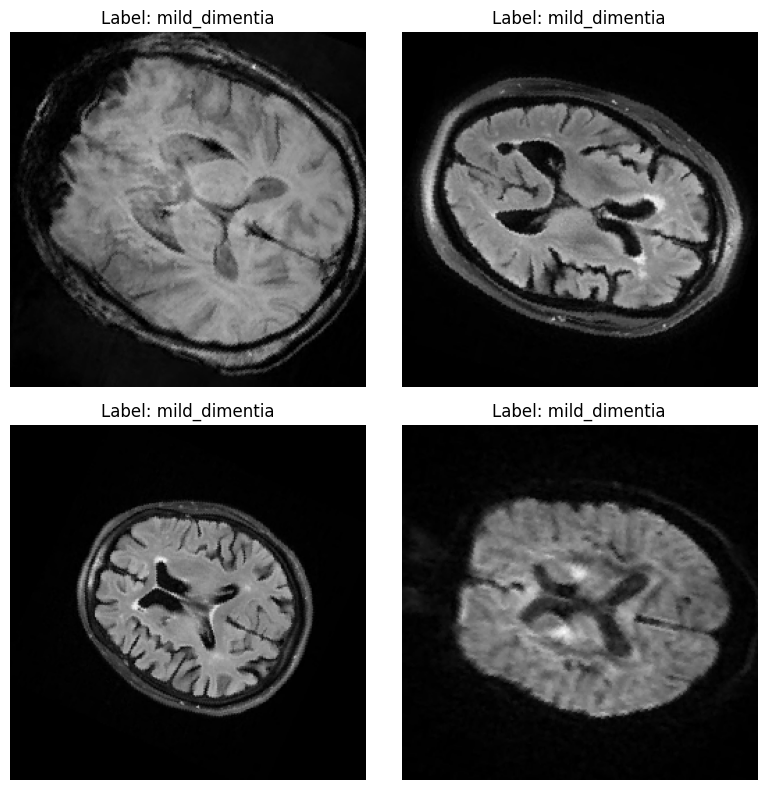

In [11]:
import matplotlib.pyplot as plt

# Display the first 4 resampled images in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for ax, img, lbl in zip(axes.flat, X_balanced[5510:5514], y_balanced[5500:5504]):
    ax.imshow(img.astype('uint8'))
    ax.set_title(f'Label: {lbl}')
    ax.axis('off')

plt.tight_layout()
plt.show()

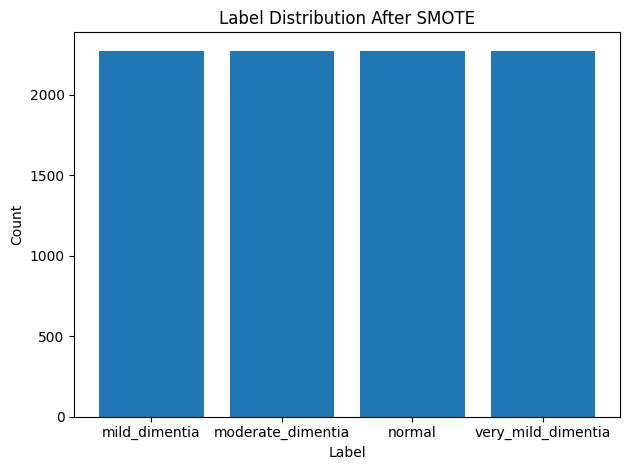

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
# import ace_tools as tools

# Calculate label distribution for the resampled labels
counts = pd.Series(y_balanced).value_counts().sort_index()
df_counts = counts.reset_index()
df_counts.columns = ['label', 'count']

# Plot the distribution
plt.figure()
plt.bar(df_counts['label'].astype(str), df_counts['count'])
plt.title("Label Distribution After SMOTE")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

# y_resampled is your array/list of string labels, e.g. ['CN', 'very_mild_dementia', …]
le = LabelEncoder()
y_encoded = le.fit_transform(y_balanced)

# Build the mapping: { original_label → encoded_int }
label_mapping = { cls: int(idx) for idx, cls in enumerate(le.classes_) }

print(label_mapping)
# e.g. {'CN': 0, 'mild_dementia': 1, 'moderate_dementia': 2, 'very_mild_dementia': 3}

{np.str_('mild_dimentia'): 0, np.str_('moderate_dimentia'): 1, np.str_('normal'): 2, np.str_('very_mild_dimentia'): 3}


In [15]:
# import numpy as np

# # ensure your arrays are in a high-precision dtype
# images_fp = X_balanced.astype(np.float64)
# labels_int = np.array(y_encoded, dtype=np.int64)

# # save to disk
# np.savez(
#     "oasis_balanced_flat.npz",
#     images=images_fp,
#     labels=labels_int,
#     label_mapping=label_mapping
# )

In [ ]:
# import os
# import numpy as np
# from PIL import Image

# # assume X_balanced is an array of shape (N, 256, 256, C)
# # and y_balanced is a 1D array of length N with integer labels
# # customize this to wherever you want to save:
# output_dir = "/home/mhs/thesis/balanced_img"

# # 1) make one subfolder per label
# for lbl in np.unique(y_balanced):
#     os.makedirs(os.path.join(output_dir, str(lbl)), exist_ok=True)

# # 2) loop and save
# for idx, (img_arr, lbl) in enumerate(zip(X_balanced, y_balanced)):
#     # convert array to PIL image
#     img = Image.fromarray(img_arr.astype('uint8'))
#     # build filepath
#     label_dir = os.path.join(output_dir, str(lbl))
#     fname = f"{idx:05d}.png"  # zero-padded filenames
#     path = os.path.join(label_dir, fname)
#     # save
#     img.save(path)
